In [1]:
import numpy as np
from skimage.io import imsave
from matplotlib import pyplot as plt

TOTAL_IMAGE_COUNT = 200
IMAGE_SIZE = (256, 256)


Bad key text.latex.unicode in file /Users/fukai/.matplotlib/stylelib/paper-default2.mplstyle, line 46 ('text.latex.unicode: True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution
Duplicate key in file PosixPath('/Users/fukai/.matplotlib/stylelib/paper-default.mplstyle'), line 38 ('legend.framealpha: 1.0')


# Simple gradient

In [2]:
def generate_test_data(
    image_count,
    sizes,
):
    np.random.seed(42)  # answer to the meaning of life, should work here too
    grid = np.array(
        np.meshgrid(
            *[np.linspace(-size // 2 + 1, size // 2, size) for size in sizes],
            indexing="ij"
        )
    )

    # Create the parabolic gradient (flatfield) with and offset (darkfield)
    gradient = np.sum(grid**2, axis=0)
    gradient = 0.01 * (np.max(gradient) - gradient) + 10
    gradient_int = gradient.astype(np.int16)

    # Ground truth, for correctness checking
    truth = gradient / gradient.mean()

    # Create an image stack and add poisson noise
    images = np.random.poisson(lam=gradient_int, size=[image_count] + list(sizes))

    return gradient, images, truth


def add_blobs(images, blob_count, blob_size, blob_intensity):
    image_count, sizes = images.shape[0], images.shape[1:]
    blob_positions = np.array(
        [np.random.randint(0, size, (image_count, blob_count)) for size in sizes]
    )
    blob_positions = np.moveaxis(blob_positions, 0, -1)

    inds = np.meshgrid(*[np.arange(size) for size in sizes], indexing="ij")
    for frame, pos in enumerate(blob_positions):
        for blob in pos:
            dist = (
                inds - np.array(blob)[(slice(None), *[np.newaxis] * len(sizes))]
            ).astype(np.float64)
            gauss_image = np.exp(-np.sum(dist**2, axis=0) / (2 * blob_size**2))
            images[frame] += blob_intensity * gauss_image
    return images

In [4]:
gradient, images, truth = generate_test_data(TOTAL_IMAGE_COUNT, IMAGE_SIZE)
images = add_blobs(images.astype(np.float64), 200, 5, 500)
images = images * np.linspace(1, 0.2, TOTAL_IMAGE_COUNT)[:, np.newaxis, np.newaxis]
# images = images + inds[0] + 100

findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.


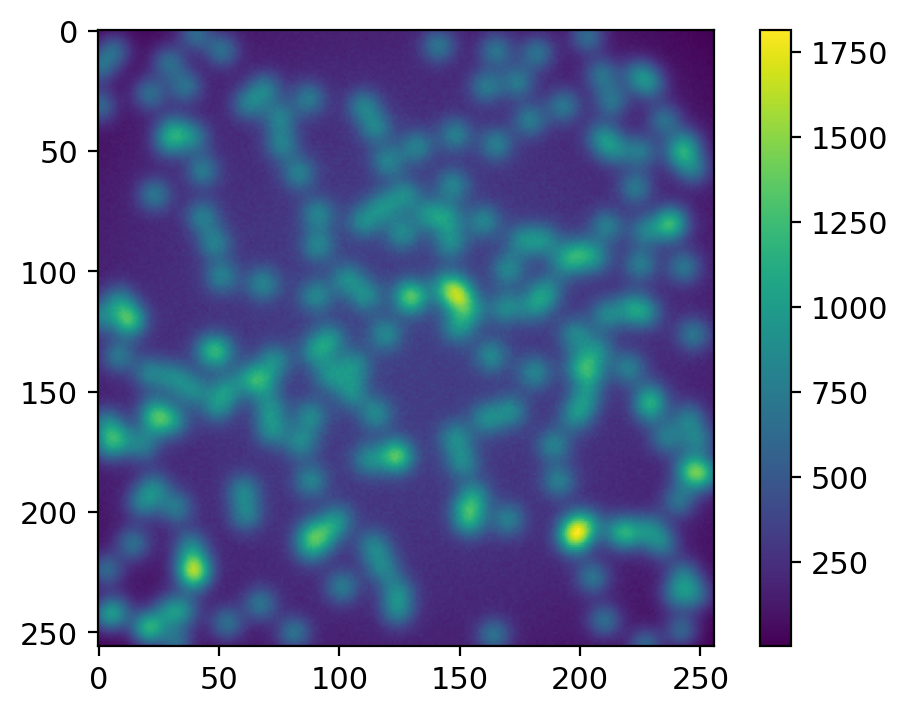

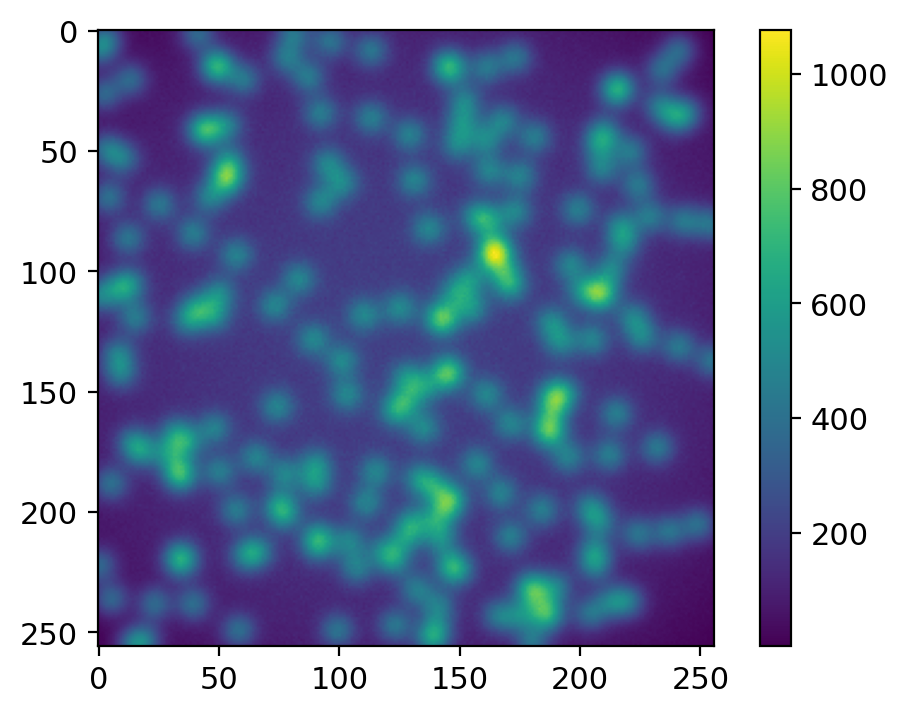

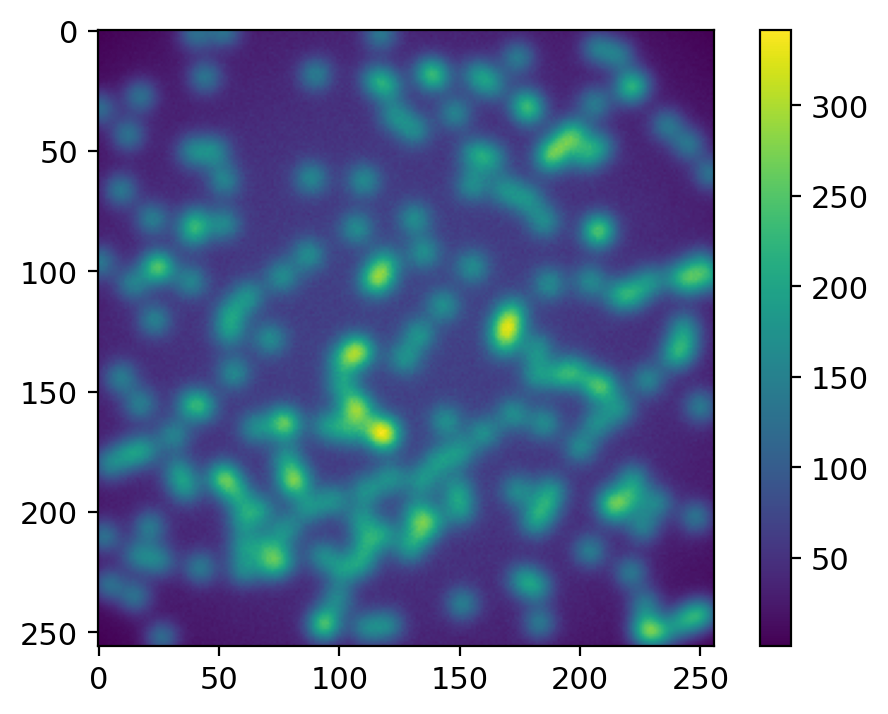

In [5]:
for i in [0, 100, 199]:
    plt.imshow(images[i])
    plt.colorbar()
    plt.show()

INFO:basicpy.basicpy:Initializing BaSiC 12145625408 with parameters: 
get_darkfield: False
lambda_flatfield_coef: 200
fitting_mode: ladmap

INFO:basicpy.basicpy:=== BaSiC fit started ===
INFO:basicpy.basicpy:reweighting iteration 0
INFO:basicpy.basicpy:single-step optimization score: 7.735739018244203e-07.
INFO:basicpy.basicpy:mean of S: 1.0.
INFO:basicpy.basicpy:Iteration 0 finished.
INFO:basicpy.basicpy:reweighting iteration 1
INFO:basicpy.basicpy:single-step optimization score: 7.963593589010998e-07.
INFO:basicpy.basicpy:mean of S: 0.9999998807907104.
INFO:basicpy.basicpy:Iteration 1 finished.
INFO:basicpy.basicpy:reweighting score: 0.01262219250202179
INFO:basicpy.basicpy:elapsed time: 0.9897524590051034 seconds
INFO:basicpy.basicpy:reweighting iteration 2
INFO:basicpy.basicpy:single-step optimization score: 8.393583925681014e-07.
INFO:basicpy.basicpy:mean of S: 1.0.
INFO:basicpy.basicpy:Iteration 2 finished.
INFO:basicpy.basicpy:reweighting score: 0.011676972731947899
INFO:basicpy

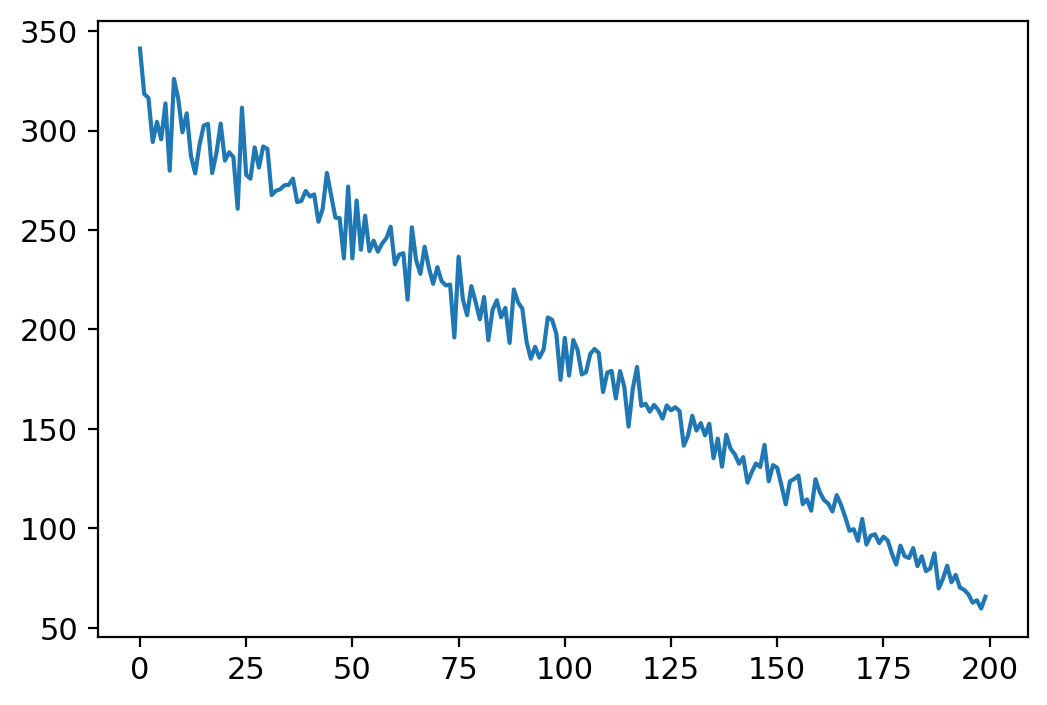

INFO:basicpy.basicpy:Initializing BaSiC 12146758496 with parameters: 
get_darkfield: False
lambda_flatfield_coef: 200
fitting_mode: approximate

INFO:basicpy.basicpy:=== BaSiC fit started ===


3938.012988198043


INFO:basicpy.basicpy:reweighting iteration 0
INFO:basicpy.basicpy:single-step optimization score: 7.391876124529517e-07.
INFO:basicpy.basicpy:mean of S: 224.74740600585938.
INFO:basicpy.basicpy:Iteration 0 finished.
INFO:basicpy.basicpy:reweighting iteration 1
INFO:basicpy.basicpy:single-step optimization score: 6.243814141271287e-07.
INFO:basicpy.basicpy:mean of S: 211.92730712890625.
INFO:basicpy.basicpy:Iteration 1 finished.
INFO:basicpy.basicpy:reweighting score: 0.013685006648302078
INFO:basicpy.basicpy:elapsed time: 1.6326313340105116 seconds
INFO:basicpy.basicpy:reweighting iteration 2
INFO:basicpy.basicpy:single-step optimization score: 7.003568498475943e-07.
INFO:basicpy.basicpy:mean of S: 201.39016723632812.
INFO:basicpy.basicpy:Iteration 2 finished.
INFO:basicpy.basicpy:reweighting score: 0.011236623860895634
INFO:basicpy.basicpy:elapsed time: 2.0247000840026885 seconds
INFO:basicpy.basicpy:reweighting iteration 3
INFO:basicpy.basicpy:single-step optimization score: 6.932968

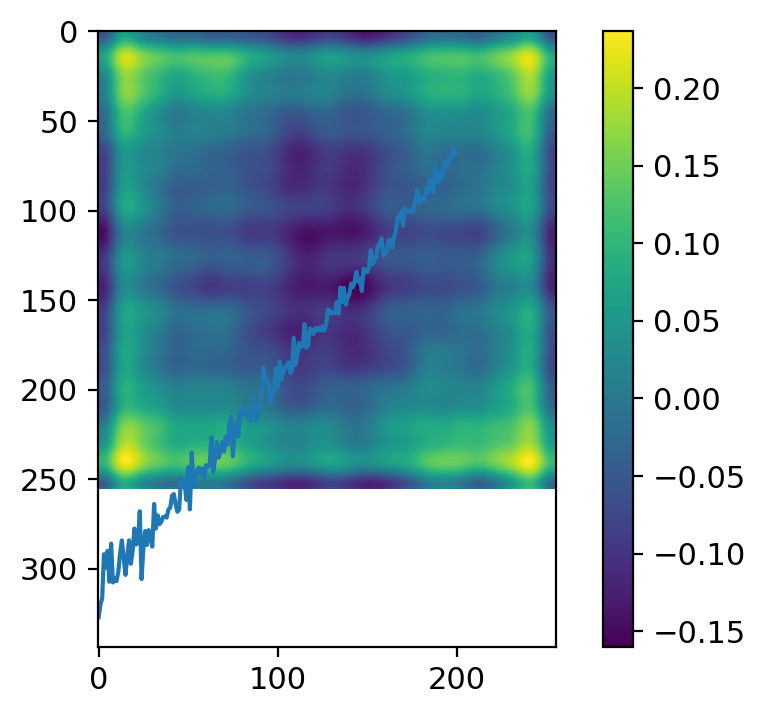

4146.631751651963


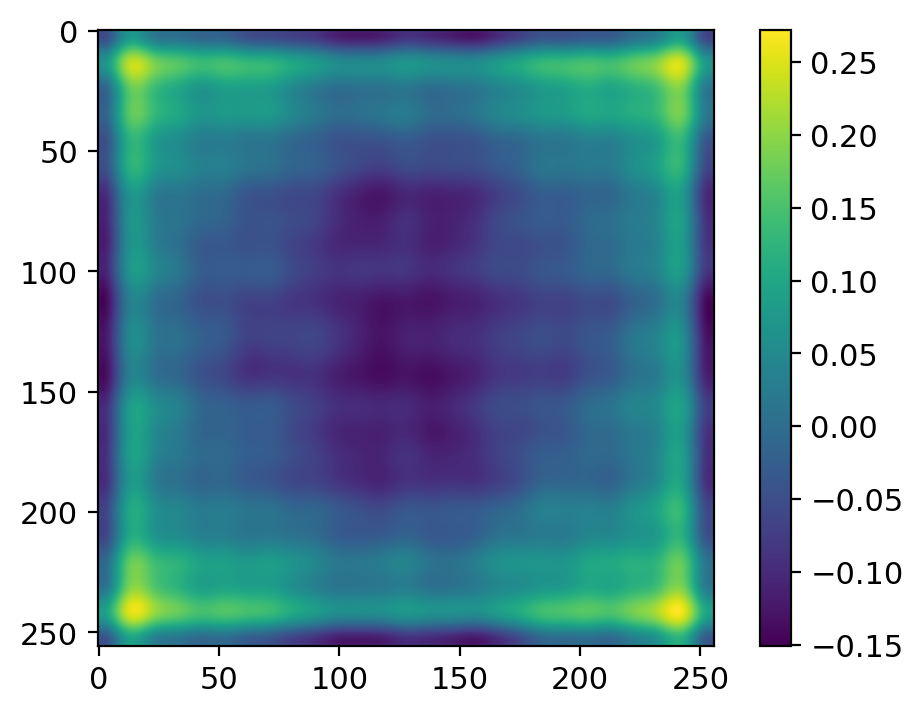

In [40]:
from basicpy import BaSiC

for method in ("ladmap", "approximate"):
    basic = BaSiC(get_darkfield=False, lambda_flatfield_coef=200, fitting_mode=method)
    basic.fit(images[:])
    plt.plot(basic.baseline)
    plt.show()
    plt.imshow(basic.flatfield - truth)
    print(np.sum(np.abs(basic.flatfield - truth)))
    plt.colorbar()

In [19]:
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion, disk

images_thresholded = np.array(
    [binary_erosion(im < threshold_otsu(im), disk(5)) for im in images]
)

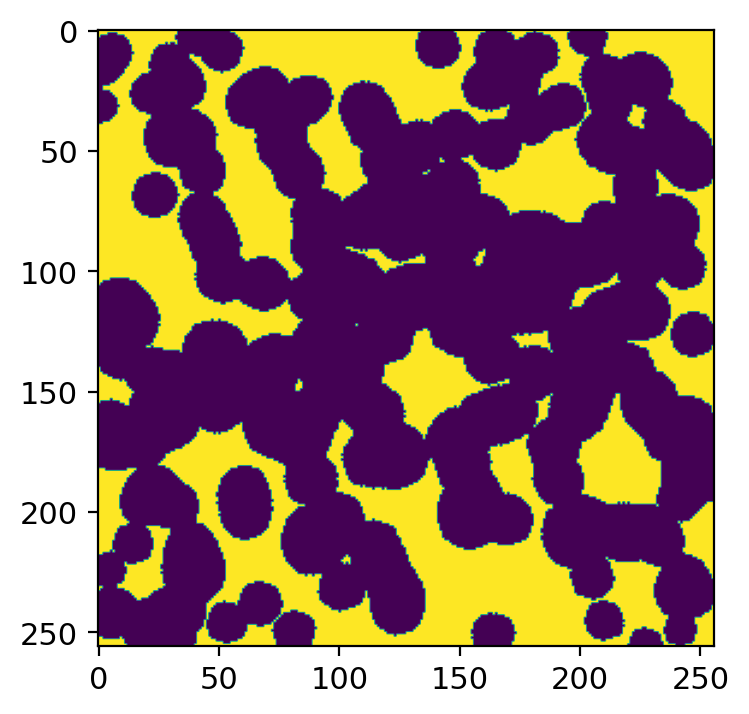

In [20]:
plt.imshow(images_thresholded[0])

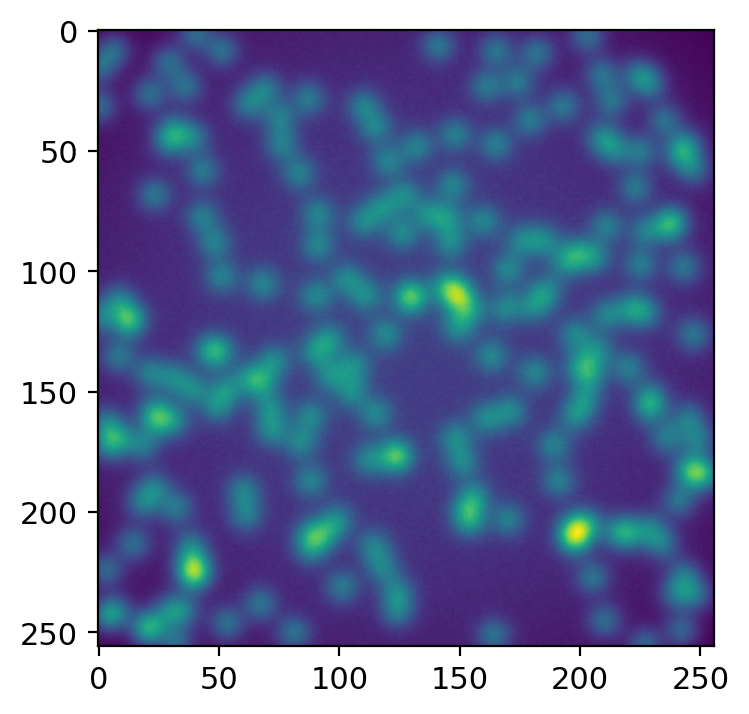

In [21]:
plt.imshow(images[0])

INFO:basicpy.basicpy:Initializing BaSiC 12143138208 with parameters: 
get_darkfield: False
lambda_flatfield_coef: 1
fitting_mode: ladmap

INFO:basicpy.basicpy:=== BaSiC fit started ===
INFO:basicpy.basicpy:reweighting iteration 0
INFO:basicpy.basicpy:single-step optimization score: 8.86517227627337e-07.
INFO:basicpy.basicpy:mean of S: 1.0.
INFO:basicpy.basicpy:Iteration 0 finished.
INFO:basicpy.basicpy:reweighting iteration 1
INFO:basicpy.basicpy:single-step optimization score: 8.348880555786309e-07.
INFO:basicpy.basicpy:mean of S: 1.0000001192092896.
INFO:basicpy.basicpy:Iteration 1 finished.
INFO:basicpy.basicpy:reweighting score: 0.06275539100170135
INFO:basicpy.basicpy:elapsed time: 1.5995830000028946 seconds
INFO:basicpy.basicpy:reweighting iteration 2
INFO:basicpy.basicpy:single-step optimization score: 7.536743282798852e-07.
INFO:basicpy.basicpy:mean of S: 1.0.
INFO:basicpy.basicpy:Iteration 2 finished.
INFO:basicpy.basicpy:reweighting score: 0.026066098362207413
INFO:basicpy.ba

1918.0575896174419


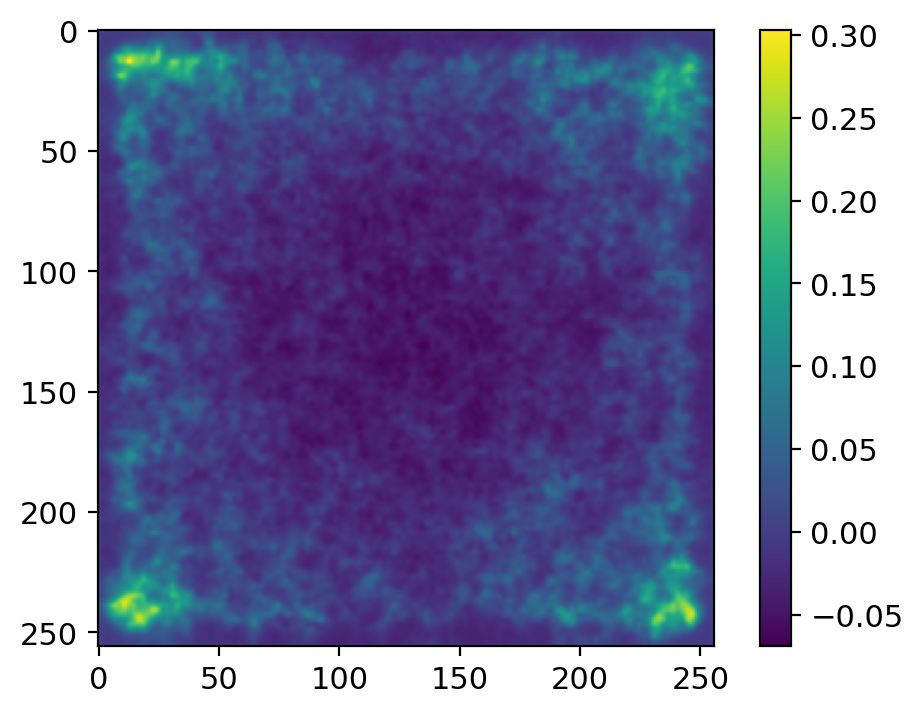

In [36]:
from basicpy import BaSiC

basic = BaSiC(get_darkfield=False, lambda_flatfield_coef=1, fitting_mode="ladmap")
assert images.shape == images_thresholded.shape
basic.fit(
    images,
    fitting_weight=images_thresholded,
)
plt.imshow(basic.flatfield - truth)
print(np.sum(np.abs(basic.flatfield - truth)))
plt.colorbar()

INFO:basicpy.basicpy:Initializing BaSiC 12144771424 with parameters: 
get_darkfield: False
lambda_flatfield_coef: 1
fitting_mode: approximate

INFO:basicpy.basicpy:=== BaSiC fit started ===
INFO:basicpy.basicpy:reweighting iteration 0
INFO:basicpy.basicpy:single-step optimization score: 8.631110972601164e-07.
INFO:basicpy.basicpy:mean of S: 227.00845336914062.
INFO:basicpy.basicpy:Iteration 0 finished.
INFO:basicpy.basicpy:reweighting iteration 1
INFO:basicpy.basicpy:single-step optimization score: 8.291571589325031e-07.
INFO:basicpy.basicpy:mean of S: 153.23971557617188.
INFO:basicpy.basicpy:Iteration 1 finished.
INFO:basicpy.basicpy:reweighting score: 0.058360036462545395
INFO:basicpy.basicpy:elapsed time: 1.7036809160053963 seconds
INFO:basicpy.basicpy:reweighting iteration 2
INFO:basicpy.basicpy:single-step optimization score: 5.812366339341679e-07.
INFO:basicpy.basicpy:mean of S: 148.22030639648438.
INFO:basicpy.basicpy:Iteration 2 finished.
INFO:basicpy.basicpy:reweighting score:

1749.1322267723212


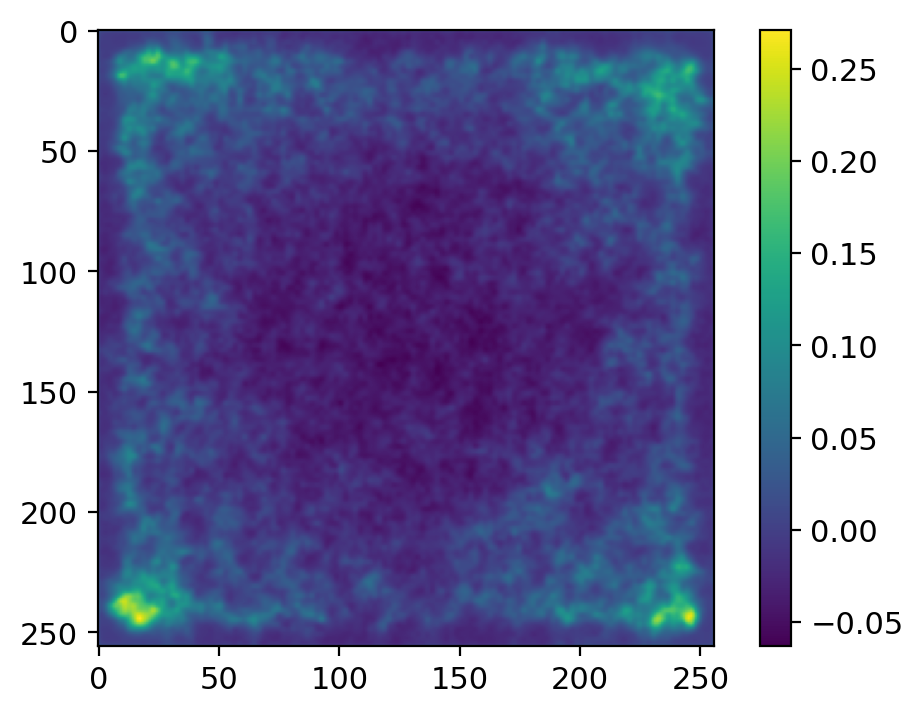

In [37]:
from basicpy import BaSiC

basic = BaSiC(get_darkfield=False, lambda_flatfield_coef=1, fitting_mode="approximate")
assert images.shape == images_thresholded.shape
basic.fit(
    images,
    fitting_weight=images_thresholded,
)
plt.imshow(basic.flatfield - truth)
print(np.sum(np.abs(basic.flatfield - truth)))
plt.colorbar()

# Gradient with blobs